In [1]:
%load_ext autoreload
%autoreload 2
import argparse
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import random
import pickle



# --- 1. Import Custom Function Modules ---
from pathlib import Path
# Locate the project root directory named "student_t_mle" among cwd ancestors (fallback to a known path)
def find_parent_dir_named(name='student_t_mle'):
    p = Path.cwd().resolve()
    if p.name == name:
        return p
    for anc in p.parents:
        if anc.name == name:
            return anc
    known = Path('/Users/antoineluciano/Documents/Recherche/student_t_mle')
    if known.exists():
        return known
    raise FileNotFoundError(f"Could not find parent dir named '{name}' in cwd ancestors or fallback path.")

parent_dir = find_parent_dir_named('student_t_mle')
os.chdir(parent_dir)
try:
    import sampler_functions as sf
except ImportError:
    print("Error: Make sure 'sampler_functions.py' is in the same directory.")
try:
    import gibbs as gs
except ImportError:
    print("Error: Make sure 'gibbs.py' is in the same directory.")
try:
    import analysis as an
except ImportError:
    print("Error: Make sure 'analysis.py' is in the same directory.")
try: 
    import densities as d
except ImportError:
    print("Error: Make sure 'densities.py' is in the same directory.")
try: 
    import jax_gibbs as gs_jax
except ImportError:
    print("Error: Make sure 'jax_gibbs.py' is in the same directory.")
    

highhigh = 0.9975
highlow = 0.995
lowhigh = 0.005
lowlow = 0.0025

In [2]:
k = 2.
mu = 2.0
m = 20
params = {
        'm': m,
        'k': k,
        'mu_true': mu, 
        'num_iterations_T': 1000,
        'prior_mean': 0.0,
        'prior_std': 10.0,
        'proposal_std_mu': 0.9,
    }


x = stats.t.rvs(df=k, loc=mu, size=m)
x_sorted = np.sort(x)
supp_q = (- 1/(2*np.sqrt(k)), 1/(2*np.sqrt(k)))  # Domain of z = psi(y) for y ~ t_k
mle = sf.get_mle(x_sorted, params)

params['mu_star'] = mle
params["z_domain"] = supp_q
params["proposal_std_z"] = 0.03

/var/folders/bc/mlt2yzpn2hsg7qskk5s47jy40000gn/T/ipykernel_54621/1100914380.py:23: RuntimeWarning: invalid value encountered in divide
  plt.plot(zs_q_tilde, q_tilde/norm_q_tilde, label=f'$\\tilde q(z)$ norm = {np.trapz(q_tilde, zs_q_tilde):.2f}')


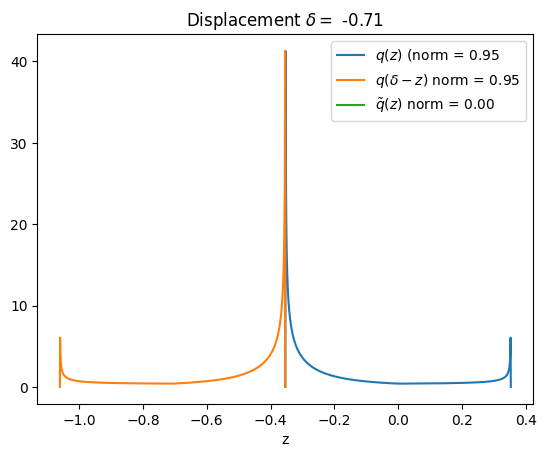

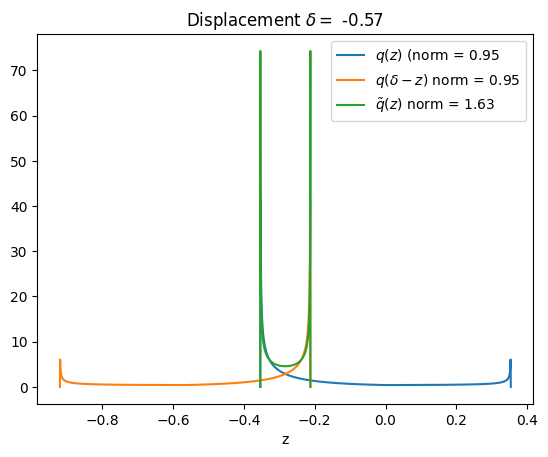

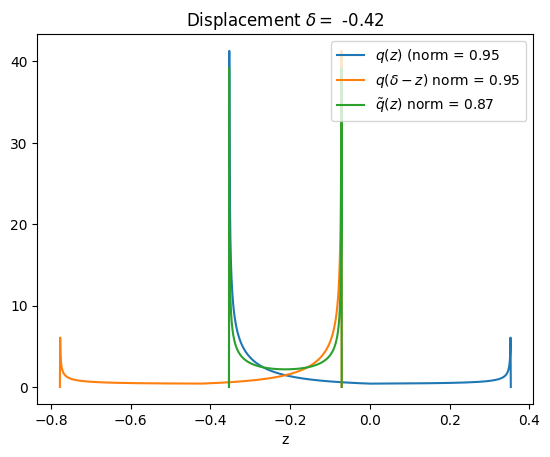

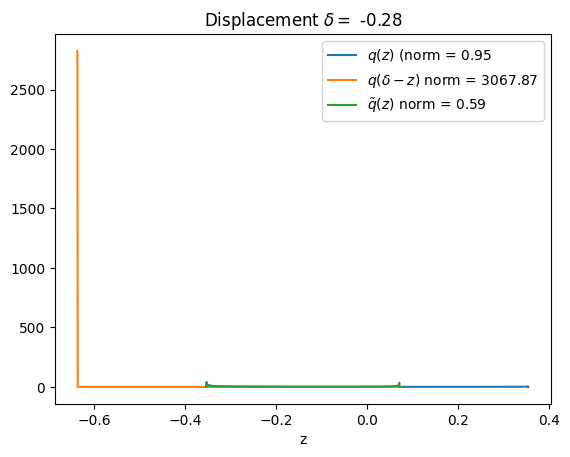

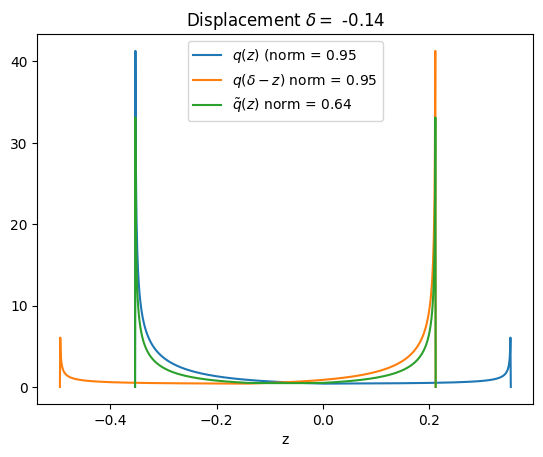

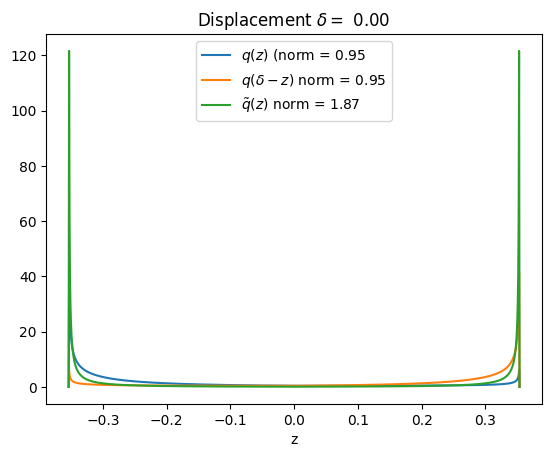

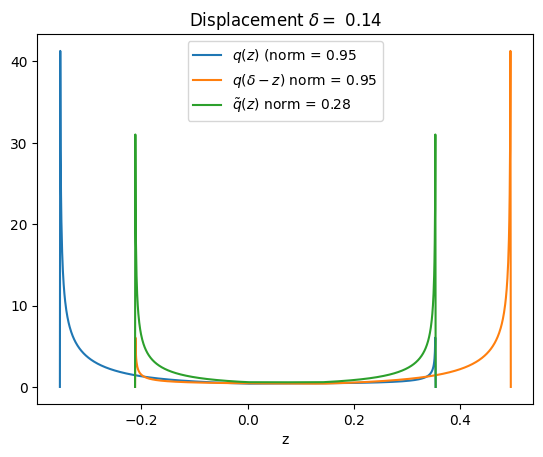

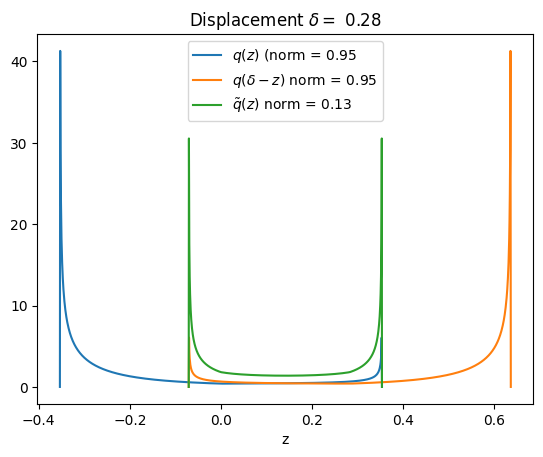

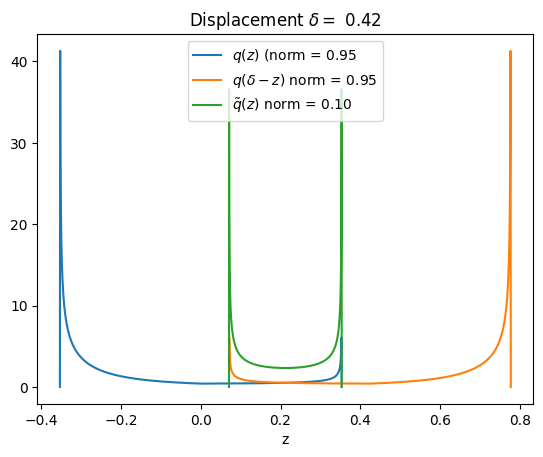

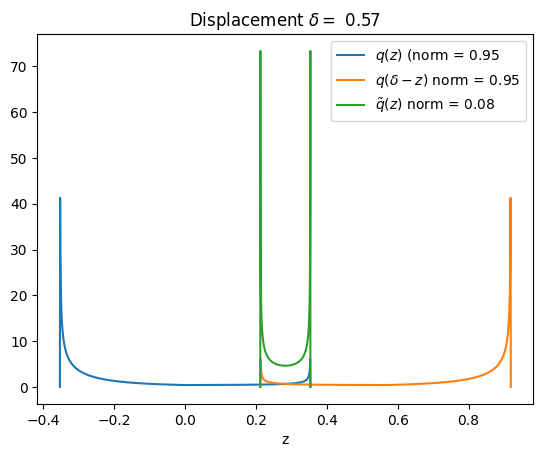

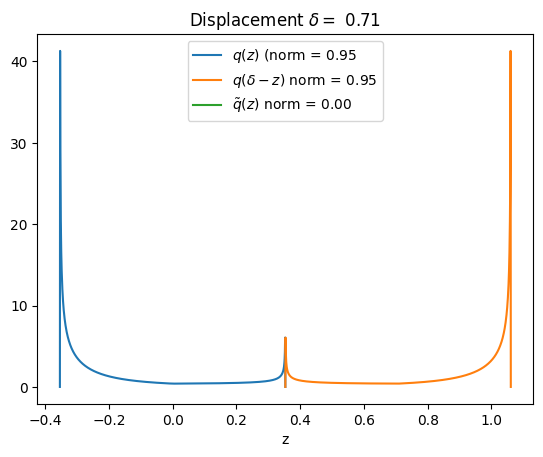

In [3]:
supp_q = (- 1/(2*np.sqrt(k)), 1/(2*np.sqrt(k)))  # Domain of z = psi(y) for y ~ t_k
supp_delta = (-1/np.sqrt(k), 1/np.sqrt(k))
epsilon = 0
n_sample = 1000
deltas = np.linspace(supp_delta[0], supp_delta[1], 11)
zs_q = np.linspace(supp_q[0]+epsilon, supp_q[1]-epsilon, n_sample)
qs = [np.exp(sf.log_q_density(z, mle, mle+1 , k, supp_q)) for z in zs_q]
norm_q = np.trapz(qs, zs_q)

for delta in deltas:
    supp_q_delta = (supp_q[0] + delta + epsilon,  supp_q[1] + delta - epsilon)
    zs_q_delta = delta + zs_q
    qs_delta = [np.exp(sf.log_q_density(delta - z, mle, mle+1 , k, supp_q)) for z in zs_q_delta]
    norm_q_delta = np.trapz(qs_delta, zs_q_delta)
    
    supp_q_tilde = (max(supp_q[0], supp_q_delta[0])+ epsilon, min(supp_q[1], supp_q_delta[1]) - epsilon)
    zs_q_tilde = np.linspace(supp_q_tilde[0]+epsilon, supp_q_tilde[1]-epsilon, n_sample)
    q_tilde = [np.exp(sf.log_q_tilde(z, delta, mle, mle+1, k, supp_q)) for z in zs_q_tilde]
    norm_q_tilde = np.trapz(q_tilde, zs_q_tilde)
    
    plt.plot(zs_q, qs/norm_q, label=f'$q(z)$ (norm = {np.trapz(qs, zs_q):.2f}')
    plt.plot(zs_q_delta, qs_delta/norm_q_delta  , label=f'$q(\\delta - z)$ norm = {np.trapz(qs_delta, zs_q_delta):.2f}')
    plt.plot(zs_q_tilde, q_tilde/norm_q_tilde, label=f'$\\tilde q(z)$ norm = {np.trapz(q_tilde, zs_q_tilde):.2f}')
    plt.legend()
    plt.title(f'Displacement $\\delta =$ {delta:.2f}')
    plt.xlabel('z')
    plt.show()
    
    
    

/var/folders/bc/mlt2yzpn2hsg7qskk5s47jy40000gn/T/ipykernel_54621/2690551934.py:25: RuntimeWarning: invalid value encountered in divide
  plt.plot(zs_q_tilde, q_tilde/norm_q_tilde, label=f'$\\tilde q(z)$ norm = {np.trapz(q_tilde, zs_q_tilde):.2f}')


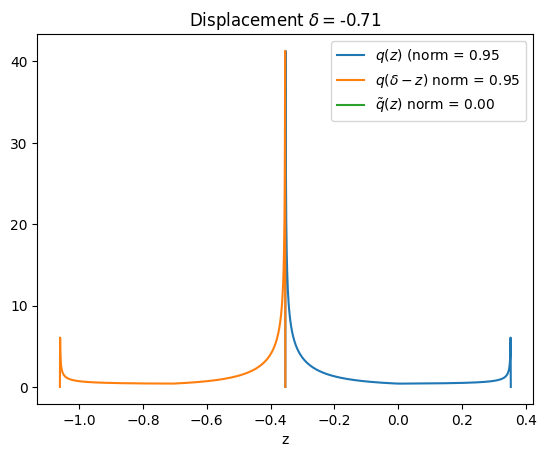

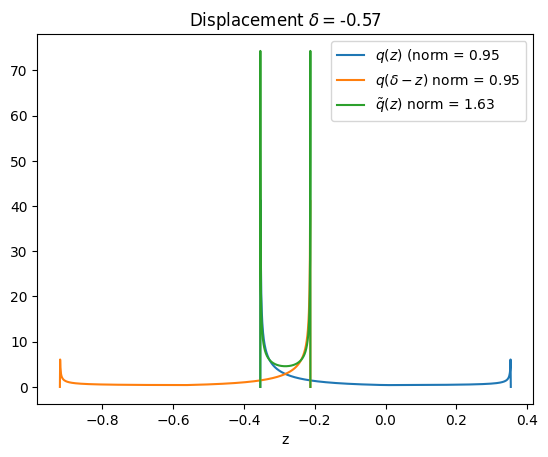

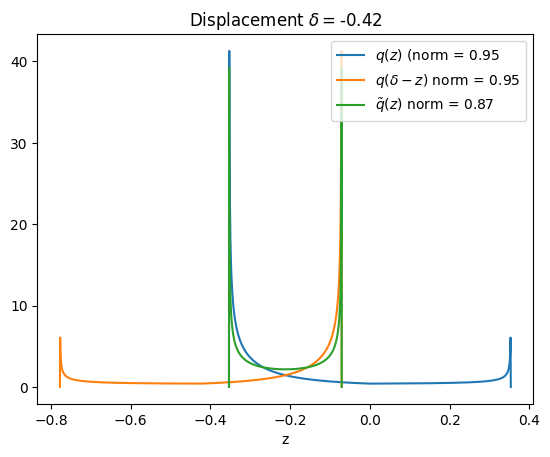

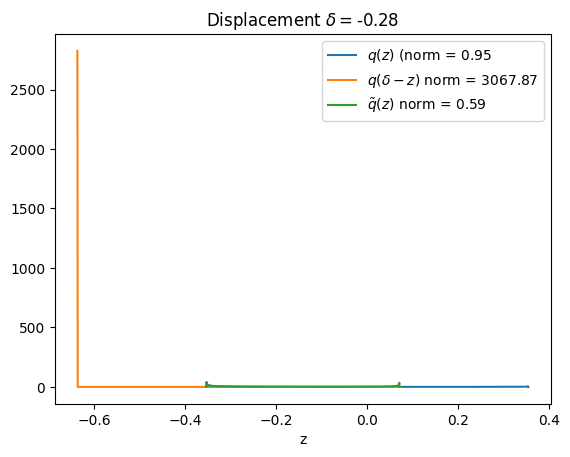

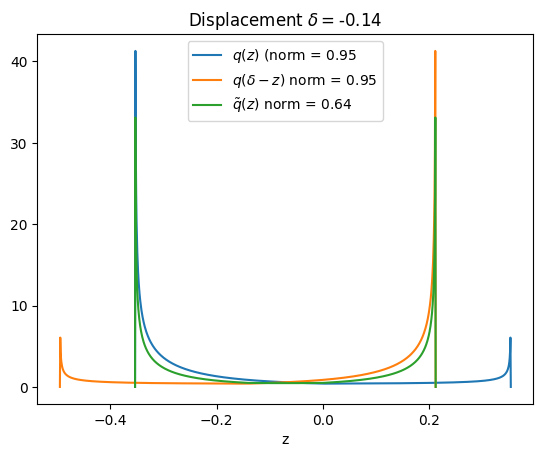

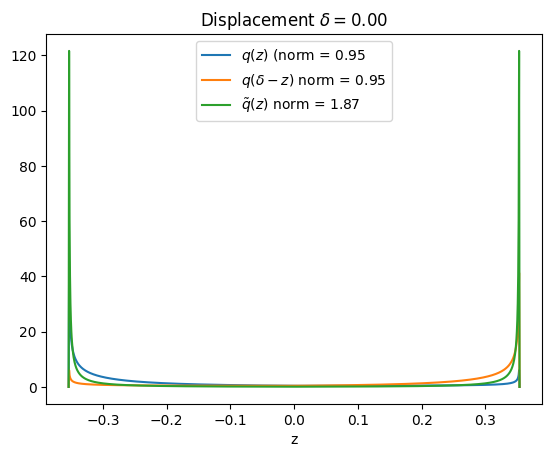

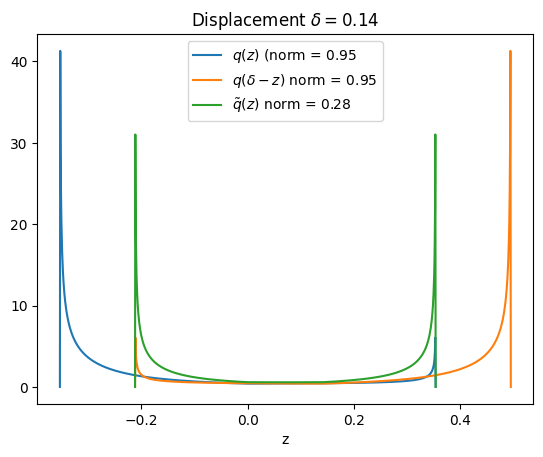

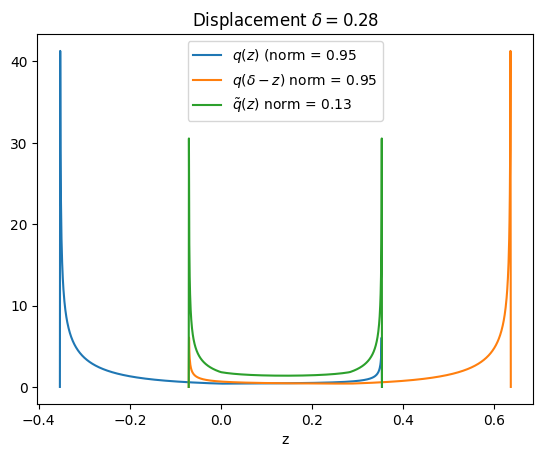

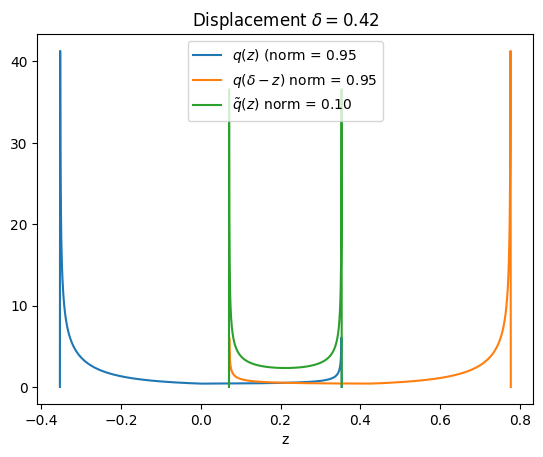

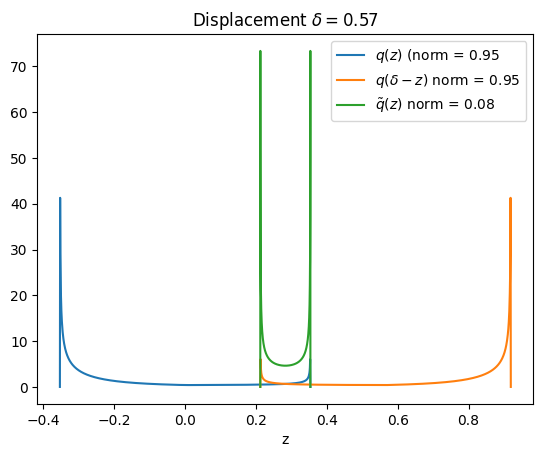

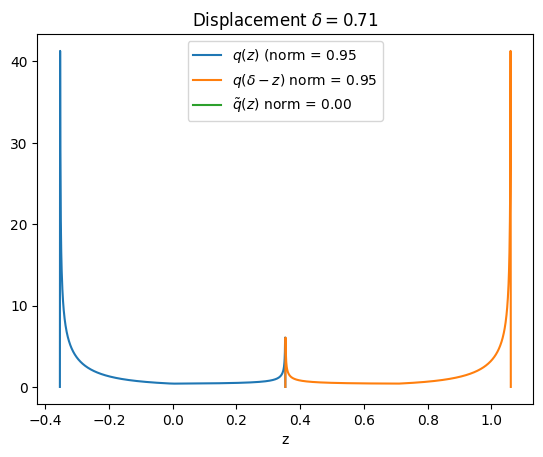

In [4]:
from densities import q_logpdf, q_tilde_logpdf

supp_q = (- 1/(2*np.sqrt(k)), 1/(2*np.sqrt(k)))  # Domain of z = psi(y) for y ~ t_k
supp_delta = (-1/np.sqrt(k), 1/np.sqrt(k))
epsilon = 0
n_sample = 1000
deltas = np.linspace(supp_delta[0], supp_delta[1], 11)
zs_q = np.linspace(supp_q[0]+epsilon, supp_q[1]-epsilon, n_sample)
qs = np.array([np.exp(q_logpdf(z, mle, mle+1 , k)) for z in zs_q])
norm_q = np.trapz(qs, zs_q)

for delta in deltas:
    supp_q_delta = (supp_q[0] + delta, supp_q[1] + delta)
    zs_q_delta = delta + zs_q
    qs_delta = np.array([np.exp(q_logpdf(delta - z, mle, mle+1 , k)) for z in zs_q_delta])
    norm_q_delta = np.trapz(qs_delta, zs_q_delta)
    
    supp_q_tilde = (max(supp_q[0], supp_q_delta[0]), min(supp_q[1], supp_q_delta[1]))
    zs_q_tilde = np.linspace(supp_q_tilde[0]+epsilon, supp_q_tilde[1]-epsilon, n_sample)
    q_tilde = np.array([np.exp(q_tilde_logpdf(z, delta, mle, mle+1, k)) for z in zs_q_tilde])
    norm_q_tilde = np.trapz(q_tilde, zs_q_tilde)

    plt.plot(zs_q, qs/norm_q, label=f'$q(z)$ (norm = {np.trapz(qs, zs_q):.2f}')
    plt.plot(zs_q_delta, qs_delta/norm_q_delta  , label=f'$q(\\delta - z)$ norm = {np.trapz(qs_delta, zs_q_delta):.2f}')
    plt.plot(zs_q_tilde, q_tilde/norm_q_tilde, label=f'$\\tilde q(z)$ norm = {np.trapz(q_tilde, zs_q_tilde):.2f}')
    plt.legend()
    plt.title(f'Displacement $\\delta =${delta:.2f}')
    plt.xlabel('z')
    plt.show()
    
    
    

In [5]:
params["num_iterations_T"] = 5000

# params["kernel"] = "uniform"
# gibbs_unif = gs.run_gibbs_sampler_mle(mle, params)

params["kernel"] = "normal"
gibbs_norm = gs.run_gibbs_sampler_mle(mle, params)

# params["kernel"] = "truncated_normal"
# gibbs_trunc_norm = gs.run_gibbs_sampler_mle(mle, params)

Running Gibbs Sampler:   9%|▉         | 447/5000 [00:04<00:46, 97.59it/s] 


KeyboardInterrupt: 

In [7]:
import jax
key = jax.random.PRNGKey(0)
params["num_iterations_T"] = 100000
gibbs_norm_jax = gs_jax.run_gibbs_sampler_mle_jax(key, mle, params)

Running Gibbs Sampler: 100%|██████████| 100000/100000 [05:01<00:00, 331.69it/s]


--- Sampling Complete ---
Mu Acceptance Rate: 0.3377
Z_i Acceptance Rate: 0.6680


In [6]:
import jax.numpy as jnp
from jax import random, jit, vmap

key = random.PRNGKey(0)
k = 5
y = random.normal(key, (100000,)) * 10.0  # des y raisonnables
z = gs_jax.psi_jax(y, k)
psi_inverse_jax_batch = vmap(gs_jax.psi_inverse_jax, in_axes=(0,None))

y1, y2 = psi_inverse_jax_batch(z, k)

# une des deux branches doit être proche de y
err1 = jnp.min(jnp.stack([
    jnp.abs(y - y1),
    jnp.abs(y - y2)
], axis=0), axis=0)

print("max |y - psi_inverse(psi(y))| =", err1.max())


max |y - psi_inverse(psi(y))| = 8.498535208900648e-12


In [ ]:
T = 5000
params["num_iterations_T"] = T
%load_ext line_profiler
%lprun -f gs_jax.run_gibbs_sampler_mle_jax -f gs_jax.update_mu_metropolis_jax gibbs_norm_jax = gs_jax.run_gibbs_sampler_mle_jax(key, mle, params)

/Users/antoineluciano/.pyenv/versions/jax_env/lib/python3.10/site-packages/line_profiler/ipython_extension.py:97: UserWarning: Adding a function with a __wrapped__ attribute. You may want to profile the wrapped function by adding update_mu_metropolis_jax.__wrapped__ instead.
  profile = LineProfiler(*funcs)
/Users/antoineluciano/.pyenv/versions/jax_env/lib/python3.10/site-packages/line_profiler/ipython_extension.py:97: UserWarning: Could not extract a code object for the object <PjitFunction of <function update_mu_metropolis_jax at 0x32b706440>>
  profile = LineProfiler(*funcs)


The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


Running Gibbs Sampler: 100%|██████████| 5000/5000 [00:08<00:00, 564.52it/s]


--- Sampling Complete ---
Mu Acceptance Rate: 0.3062
Z_i Acceptance Rate: 0.6672


Timer unit: 1e-09 s

Total time: 8.84605 s
File: /Users/antoineluciano/Documents/Recherche/student_t_mle/jax_gibbs.py
Function: run_gibbs_sampler_mle_jax at line 253

Line #      Hits         Time  Per Hit   % Time  Line Contents
   253                                           def run_gibbs_sampler_mle_jax(key: jax.random.PRNGKey, mu_star : float, params: dict) -> dict:
   254         1       1000.0   1000.0      0.0      T = params['num_iterations_T']
   255         1          0.0      0.0      0.0      m = params['m']
   256         1    1190000.0    1e+06      0.0      mus = jnp.zeros(T+1)
   257         1     306000.0 306000.0      0.0      xs = jnp.zeros((T+1, m))
   258                                               
   259         1     290000.0 290000.0      0.0      x_0 = jnp.ones(m) * mu_star
   260         1    1492000.0    1e+06      0.0      xs = xs.at[0, :].set(x_0)
   261                                               
   262         1          0.0      0.0      0.0      

In [ ]:
x_0 = np.ones(m) * mle
mu_0 = mle
old_gibbs_norm = sf.run_main_gibbs_sampler(params, mu_0, x_0)


--- Starting the Main Gibbs Sampler ---


Running Gibbs Sampler: 100%|██████████| 4999/4999 [00:53<00:00, 93.98it/s] 


--- Sampling Complete ---
Mu Acceptance Rate: 0.3277
Z_i Acceptance Rate: 0.7285


In [11]:
from densities import get_normalized_posterior_mle_pdf
kde_pdf = get_normalized_posterior_mle_pdf(mle, params, num_simulations=50000)


--- Computing Benchmark KDE from 50000 simulations ---
(This is computationally intensive and will take some time...)
  Processing simulation 10000/50000...
  Processing simulation 20000/50000...
  Processing simulation 30000/50000...
  Processing simulation 40000/50000...
  Processing simulation 50000/50000...


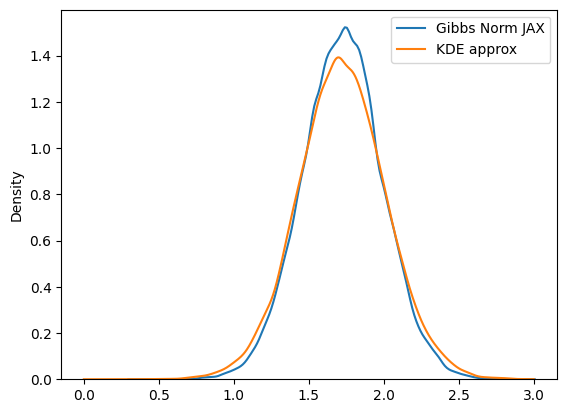

In [13]:
# sns.kdeplot(gibbs_norm["mu_chain"], label = "Gibbs Norm")
sns.kdeplot(gibbs_norm_jax["mu_chain"], label = "Gibbs Norm JAX")
# sns.kdeplot(gibbs_unif["mu_chain"], label = "Gibbs Unif")
# sns.kdeplot(gibbs_trunc_norm["mu_chain"], label = "Gibbs Truncnorm")
# sns.kdeplot(old_gibbs_norm["mu_chain"], label = "Old Gibbs Norm")
mus = np.linspace(0,3, 1000)
plt.plot(mus, kde_pdf(mus), label = "KDE approx")
plt.legend()

In [ ]:
gibbs_norm_jax

{'mu_acceptance_rate': 0.3062,
 'pair_acceptance_rate': Array(1., dtype=float32),
 'z_i_acceptance_rate': Array(0.66722, dtype=float32),
 'mu_chain': Array([1.7659132, 1.7659132, 1.7659132, ..., 1.4424562, 1.4424562,
        1.4424562], dtype=float32),
 'x_chain': Array([[ 1.7659132 ,  1.7659132 ,  1.7659132 , ...,  1.7659132 ,
          1.7659132 ,  1.7659132 ],
        [ 1.7659132 ,  1.7659132 ,  1.7659132 , ...,  1.6710324 ,
          1.7659132 ,  1.7659132 ],
        [ 1.7659132 ,  1.7659132 ,  1.7659132 , ...,  1.7659132 ,
          1.7659132 ,  1.7659132 ],
        ...,
        [ 1.9788291 ,  1.9118111 ,  2.3688767 , ..., -0.23540139,
          1.2515609 ,  1.8495176 ],
        [ 2.292222  ,  0.99694073,  1.9031973 , ...,  1.8195041 ,
          0.5372087 ,  1.9805088 ],
        [ 2.292222  ,  2.8551645 ,  0.648036  , ...,  2.3740034 ,
          1.6288736 ,  1.2728653 ]], dtype=float32)}

In [ ]:
mle_jax


array([1.76591327, 1.76591327, 1.76591327, ..., 1.76591327, 1.76591327,
       1.76591327])

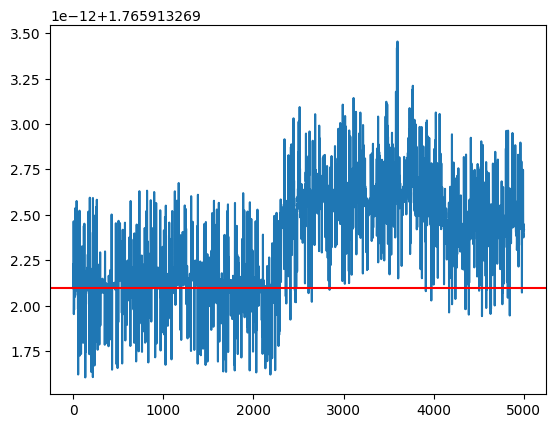

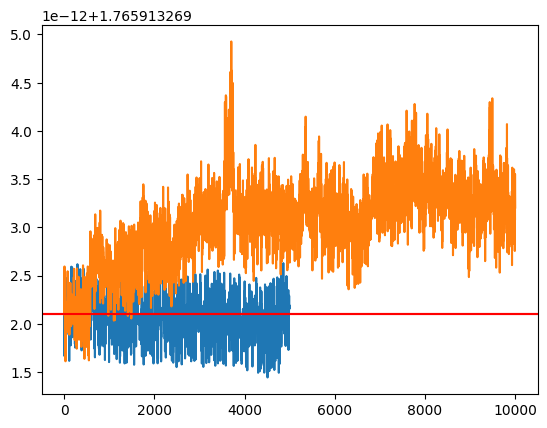

In [ ]:
mle_norm = np.zeros(gibbs_norm["x_chain"].shape[0])
for i, x in enumerate(gibbs_norm["x_chain"]):
    mle_norm[i] = sf.get_mle(x, params)
plt.plot(mle_norm)
plt.axhline(mle, color='red')
plt.show()

mle_old = np.zeros(old_gibbs_norm["x_chain"].shape[0])
for i, x in enumerate(old_gibbs_norm["x_chain"]):
    mle_old[i] = sf.get_mle(x, params)
plt.plot(mle_old)
plt.axhline(mle, color='red')
plt.show()
mle_jax = np.zeros(gibbs_norm_jax["x_chain"].shape[0])
for i, x in enumerate(gibbs_norm_jax["x_chain"]):
    mle_jax[i] = sf.get_mle(x, params)  
plt.plot(mle_jax)
plt.axhline(mle, color='red')   
plt.show()

In [ ]:
mle_jax

array([2.23520041, 2.23520041, 2.23520052, ..., 2.23540962, 2.23541605,
       2.23539412])

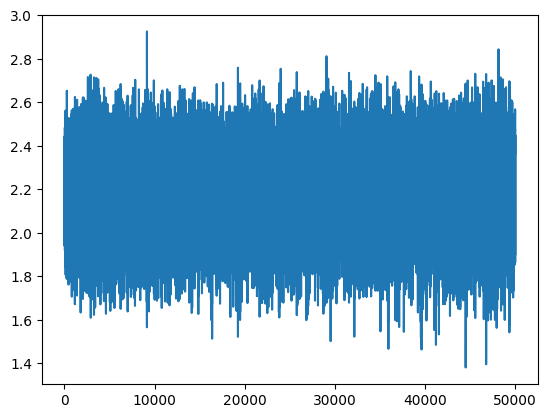

In [ ]:
plt.plot(gibbs_norm_jax["mu_chain"])

KeyError: 'x_chain'

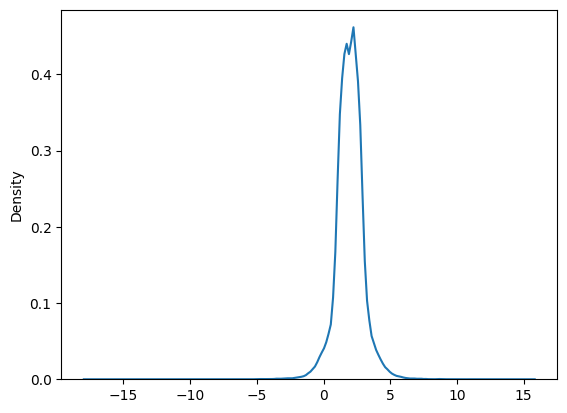

In [ ]:
sns.kdeplot(gibbs_norm["x_chain"].flatten(), label = "Gibbs Norm x")
sns.kdeplot(old_gibbs_norm["x_chain"].flatten(), label = "Old Gibbs Norm x")

In [ ]:
from jax_gibbs import update_x_full_jax
import jax.numpy as jnp
import jax
x0 = jnp.ones(m) * mle
key = jax.random.PRNGKey(0)
for i in range(10):
    key, _key = jax.random.split(key)
    x0, pair_acc, z_acc = update_x_full_jax(_key, x0, mle, mle, params['k'], params['proposal_std_z'])
    



In [ ]:
x0

Array([1.9701173, 1.9941964, 2.1627138, 1.9741256, 1.9839888, 1.8693932,
       1.6643562, 2.3255525, 1.8167193, 2.070729 , 1.9564058, 2.0872753,
       2.0250149, 1.7046428, 1.9940102, 2.2469893, 1.7749195, 2.0629103,
       2.0226278, 1.8257331], dtype=float32)

# test mu

In [ ]:
from tqdm import tqdm
T = 10000
mus_jax = jnp.zeros(T+1)
mus = np.zeros(T+1)
mus [0] = mle
mus_jax = mus_jax.at[0].set(mle)
key = jax.random.PRNGKey(0)
sigma_mu = params['proposal_std_mu']
prior_loc = params['prior_mean']
prior_scale = params['prior_std']
x = stats.t.rvs(df=k, loc=0, size=m)
for t in tqdm(range(1, T+1)):
    key, _key = jax.random.split(key)
    mu_new, _ = gs_jax.update_mu_metropolis_jax(_key, mus_jax[t-1], x, sigma_mu, prior_loc, prior_scale, k)
    
    mus_jax = mus_jax.at[t].set(mu_new)
    
    mu_new  = sf.update_mu_metropolis(mus[t-1], x, params)
    mus[t] = mu_new
    

100%|██████████| 10000/10000 [00:08<00:00, 1179.88it/s]


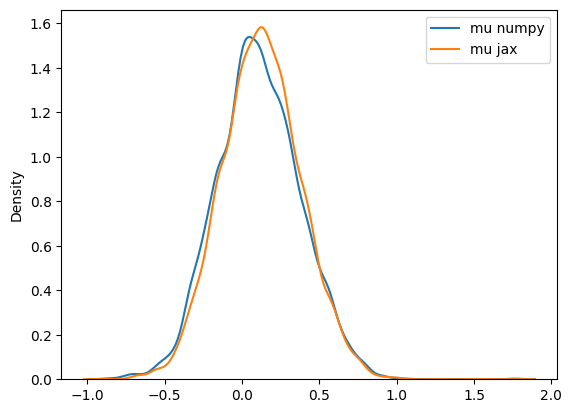

In [ ]:
sns.kdeplot(mus, label='mu numpy')
sns.kdeplot(mus_jax, label='mu jax')
plt.legend()